This exercise is based on Prof. A. Ng lectures on machine learning (Stanford U.)

# Exercise 3: Linear regression

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#from ipywidgets import interact
from functools import partial
from scipy.optimize import fmin_bfgs
from functools import partial
from os.path import join

## Plotting scatter data

Load data from exercise one: CSV file with two columns x,y of data.<br>
x is the population of a city (in 10k) and y is the revenue of a food truck in that city (in k$).

In [4]:
data=np.loadtxt(open(join('data','ex4data1.csv'),'rb'),delimiter=',')
print('Number of data points (m):',data.shape[0])
print('Dataset shape:',data.shape)

Number of data points (m): 97
Dataset shape: (97, 2)


Extract from matrix of data the two columns, X and y

In [5]:
x,y = np.matrix(data[:,:-1]),np.matrix(data[:,-1:]) #X is everything except last column
print(x.shape,y.shape) #These are column vectors
num_features, dataset_size = x.shape[1], x.shape[0]

(97, 1) (97, 1)


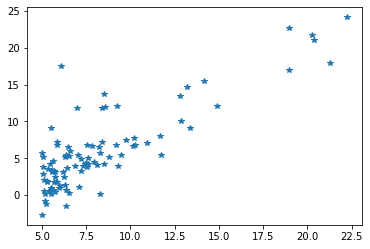

In [7]:
plt.plot(x,y,'*');

## Gradient descent

First we rewrite the input data in matrix form X=[ 1 , x ] so that we can rewrite our (linear) hypotesis as $h_\theta(x^{(i)})=\sum_{j=0\dots n}(x_j\theta_j)$, with $\theta=[\theta_0,\cdots,\theta_n]$ the vector of parameters. With the matrix notation, being $h_\theta(x)$ the vector of the value of the hypothesis: $h_\theta(x)=X\cdot\theta$

In [9]:
X=np.hstack( (np.ones_like(x), x) )
X

matrix([[ 1.    ,  6.1101],
        [ 1.    ,  5.5277],
        [ 1.    ,  8.5186],
        [ 1.    ,  7.0032],
        [ 1.    ,  5.8598],
        [ 1.    ,  8.3829],
        [ 1.    ,  7.4764],
        [ 1.    ,  8.5781],
        [ 1.    ,  6.4862],
        [ 1.    ,  5.0546],
        [ 1.    ,  5.7107],
        [ 1.    , 14.164 ],
        [ 1.    ,  5.734 ],
        [ 1.    ,  8.4084],
        [ 1.    ,  5.6407],
        [ 1.    ,  5.3794],
        [ 1.    ,  6.3654],
        [ 1.    ,  5.1301],
        [ 1.    ,  6.4296],
        [ 1.    ,  7.0708],
        [ 1.    ,  6.1891],
        [ 1.    , 20.27  ],
        [ 1.    ,  5.4901],
        [ 1.    ,  6.3261],
        [ 1.    ,  5.5649],
        [ 1.    , 18.945 ],
        [ 1.    , 12.828 ],
        [ 1.    , 10.957 ],
        [ 1.    , 13.176 ],
        [ 1.    , 22.203 ],
        [ 1.    ,  5.2524],
        [ 1.    ,  6.5894],
        [ 1.    ,  9.2482],
        [ 1.    ,  5.8918],
        [ 1.    ,  8.2111],
        [ 1.    ,  7

The first 5 rows being:

In [6]:
X[0:5,:]

matrix([[1.    , 6.1101],
        [1.    , 5.5277],
        [1.    , 8.5186],
        [1.    , 7.0032],
        [1.    , 5.8598]])

This is the (column) vector of the parameters we want to fit, initialized at zero.

In [10]:
theta=np.matrix(np.zeros(X.shape[1])).T
theta

matrix([[0.],
        [0.]])

The cost function is defined as:<br>
$J(\theta_0,\dots,\theta_m)=\frac{1}{2m}\sum_{i=0\dots m}(h_\theta(x^{(i)})-y^{(i)})^2$<br>
$J(\theta)=\frac{1}{2m}\sum_{i=0\dots m}((\sum_{j=0\dots n}(x_n^{(i)}\theta_n))-y^{(i)})^2$<br>
We want minimize this function for $\theta$. Using the matrix notation, rewriting the cost function to be:<br>
$J(\theta)=\frac{1}{2m}(X\cdot\theta-y)^T(X\cdot\theta-y)$<br>

In [11]:
def costF(X,y,theta):
    '''Cost function.
    
    This function evaluates the cost of a linear model given the feature 
    matrix, observed results and the model parameter vector.
    
    :param X: design matrix with column of 1.
    :type X: np.matrix of shape (dataset_size, n_features)
    :param y: Values 
    :type y: np.matrix of shape (dataset_size, 1)
    :param theta: model parameters
    :type theta: np.matrix of shape (n_features, 1)
    :returns: value of cost function
    :rtype: float
    '''
    cost = .5/len(y)*((X*theta-y).T)*((X*theta)-y)
    assert(cost.shape==(1,1))
    return cost[0,0]

The value of the cost function on the zero-itialized parameters:

In [12]:
print('Value of cost function at initial point',theta.T,':',costF(X,y,theta))

Value of cost function at initial point [[0. 0.]] : 32.07273387745567


To calculate the fit values of the parameters using the gradient descent we iteratively calcualte:<br> 
$\theta_j := \theta_j - \alpha\frac{\partial}{\partial\theta_j}J(\theta)$<br>
Updating all theta simultaneously.<br>
That will converge to (since the hypothesis is linear) the global unique solution for small $\alpha$:<br>
$\frac{\partial}{\partial\theta_j}J=\frac{1}{2m}\sum_{i=1\dots m}(h_\theta(x^{(i)})-y^{(i)})^2=\frac{1}{2m}\sum_{i=1\dots m}(\sum_{j=0\dots n}x^{(i)}_j\theta_j - y^{(i)})^2=\frac{1}{m}\sum_{i=1\dots m}(h_\theta(x^{(i)})-y^{(i)})x^{(i)}_j$<br>
Considering the features vector $x^{(i)}=[1,x_1^{(i)},...]$, we can build now the design matrix $X$ with each row the transpose of the feature vectors:<br>
$
\begin{bmatrix}
    \dots & x^{(1)T} & \dots \\
    \dots & x^{(2)T} & \dots \\
    \dots & \dots & \dots \\
    \dots & x^{(m)T} & \dots \\
    \end{bmatrix}
=
\begin{bmatrix}
1 & x_1^{(1)} & \dots & x_n^{(1)} \\
1 & x_1^{(2)} & \dots & x_n^{(2)} \\
\dots & \dots & \dots & \dots \\
1 & x_1^{(m)} & \dots & x_n^{(m)} \\
\end{bmatrix}
$<br>
In matrix notation, with $X\in\mathbb{R}^{m\times(n+1)}~,~y\in\mathbb{R}^m~,~\theta\in\mathbb{R}^{n+1}$:<br>
$\frac{\partial}{\partial\theta_j}J(\theta)=\frac{1}{m}(X\cdot\theta-y)^T\cdot X_{j}$ where $X_j$ is the $j-th$ column of the features matrix, and thus $X_j\in\mathbb{R}^m$.<br>
If we write the equation in matrix form, using the feature matrix $X$ on the right hand side, then we can read the equation providing a row-vector of the solution $\theta$, to get the column-vector notation:<br>
$\theta := \theta - \frac{\alpha}{m} ((X\cdot\theta-y)^T\cdot X)^T = \theta - \frac{\alpha}{m}X^T\cdot(X\cdot\theta-y)$

Here it is the gradient descend algorithm:

In [13]:
theta0=np.matrix(np.zeros(X.shape[1])).T # Inital values are zeros
def descendF(X, y, theta0, alpha, steps, cost_fun):
    '''Gradient descend.
    
    This function implements the gradient descend algorithm.
    
    :param X: features matrix.
    :type X: np.matrix of shape (dataset_size, n_features)
    :param y: observed vaues
    :type y: np.matrix of shape (dataset_size, 1)
    :param theta0: initial model parameters values
    :type theta0: np.matrix of shape (n_features, 1)
    :param alpha: gradient descent step size parameter
    :type alpha: float
    :param steps: number of steps
    :type steps: int
    :param cost_fun: cost function to use
    :type: (X,y,theta) -> float
    :returns: final model parameters and costs list
    :rtype: (float, list(float))
    '''
    Js=[]
    theta=theta0
    for i in range(steps):
        #Calulcate cost:
        c = cost_fun(X,y,theta)
        #Add current cost to list of costs
        Js.append(c)
        theta = theta - (alpha/len(y))*((X.T)*(X*theta-y))
        #print(theta.shape,theta)
        #break
    return (theta,Js)

# Fix default values of extra parameters, so we can handly call descend(X,y,theta)
descend_default = partial(descendF,alpha=0.01,steps=1500,cost_fun=costF)

### Problem solution with gradient descend

Optimal solution: [[-3.63029144  1.16636235]]


Text(0, 0.5, '$J(\\theta_{sol})$')

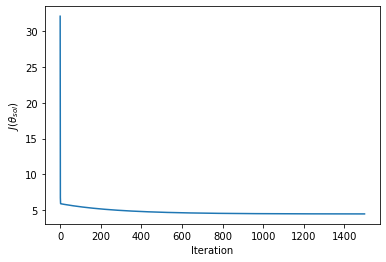

In [14]:
#The values of alpha and steps are matching the solution of the exercise. Probalby not optimal
theta,js=descend_default(X,y,theta0)
print('Optimal solution: ',end='')
print(theta.T)
plt.plot(js)
plt.xlabel('Iteration')
plt.ylabel(r'$J(\theta_{sol})$')

### Plot of fit result

In [15]:
print(theta)

[[-3.63029144]
 [ 1.16636235]]


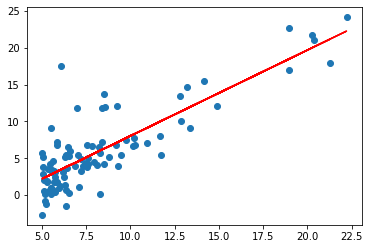

In [16]:
plt.scatter(data[:,0],data[:,1]);
plt.plot(X[:,1],X*theta,color='r');

### Contour plot of the cost funtion

Solution: [[-3.63029144  1.16636235]]  Cost:  4.483388256587727


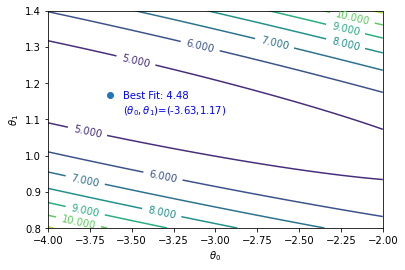

In [17]:
print('Solution:',theta.T,' Cost: ',costF(X,y,theta))
#Some gymnastic: first let's make some points
#around the solutions
#Make the points in 2D matrixes for the contour function
t0v,t1v=np.meshgrid(np.linspace(-2,-4,100),np.linspace(0.8,1.4,100))
#Let's vectorize the cost function so we can pass the
#points of the grid
vf=np.vectorize(lambda t0,t1: costF(X,y,np.matrix([t0,t1]).T))
#Costs for the points we want
js=vf(t0v,t1v)
cs=plt.contour(t0v,t1v,js)
plt.clabel(cs);
plt.plot(theta[0],theta[1],marker='o');
plt.text(theta[0]+0.08,theta[1]-0.01,'Best Fit: %3.2f'%costF(X,y,theta),color='b');
plt.text(theta[0]+0.08,theta[1]-0.05,r'($\theta_0,\theta_1$)=(%3.2f,%3.2f)'%(theta[0],theta[1]),color='b');
plt.xlabel(r'$\theta_0$');
plt.ylabel(r'$\theta_1$');
#fs=evalCostF(xv,yv)

### Multi-dimensional data
In this case with $x\in\mathbb{R}^{n+1}=[1,x_1,\dots,x_n]$ is the vector of the features and a constant term 1 and $\theta\in\mathbb{R}^{n+1}$ the vector of the paramters, we can write the hypothesis as:<br>
$h_\theta(x)=\theta^T\cdot x=x^T\cdot\theta$

In [18]:
data=np.loadtxt(open(join('data','ex4data2.csv'),'rb'),delimiter=',')

The data now have three columns. The first two being the features and the third one the outcome: square feet of the apartment and number of rooms p

In [19]:
#print(data[:10,:])
X,y=np.matrix(data[:,:-1]),np.matrix(data[:,-1:])

In [21]:
y = theta0 + tetha1*x1 + theta2*x2

matrix([[399900.],
        [329900.],
        [369000.],
        [232000.],
        [539900.],
        [299900.],
        [314900.],
        [198999.],
        [212000.],
        [242500.],
        [239999.],
        [347000.],
        [329999.],
        [699900.],
        [259900.],
        [449900.],
        [299900.],
        [199900.],
        [499998.],
        [599000.],
        [252900.],
        [255000.],
        [242900.],
        [259900.],
        [573900.],
        [249900.],
        [464500.],
        [469000.],
        [475000.],
        [299900.],
        [349900.],
        [169900.],
        [314900.],
        [579900.],
        [285900.],
        [249900.],
        [229900.],
        [345000.],
        [549000.],
        [287000.],
        [368500.],
        [329900.],
        [314000.],
        [299000.],
        [179900.],
        [299900.],
        [239500.]])

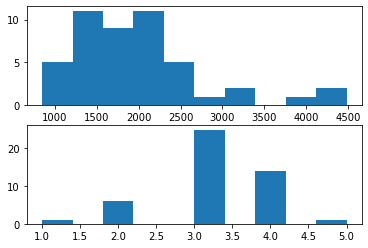

In [22]:
plt.subplot(211)
plt.hist(data[:,0])
plt.subplot(212)
plt.hist(data[:,1]);

### Data normalization

The features have very different ranges, to make the gradient descent more efficient, first we normalize the features to make them all more or less on the same scale.<br>
$ x'^{(i)} = \frac{x^{(i)}-\mu}{\sigma}$

In [23]:
avgs=np.mean(X,axis=0)
stds=np.std(X,axis=0)
print('mean=',avgs)
print ('std=',stds)

mean= [[2000.68085106    3.17021277]]
std= [[7.86202619e+02 7.52842809e-01]]


First we build two $m\times2$ matrixes wich columns are means and standard deviations respectively.

In [24]:
_avgs = np.matrix( len(data)*avgs.tolist())
_stds = np.matrix( len(data)*stds.tolist())
print('Columns are features')
print('Means matrix:\n ',_avgs[0:3,:],_avgs.shape)
print('Std dev matrix:\n ',_stds[0:3,:],_stds.shape)

Columns are features
Means matrix:
  [[2000.68085106    3.17021277]
 [2000.68085106    3.17021277]
 [2000.68085106    3.17021277]] (47, 2)
Std dev matrix:
  [[7.86202619e+02 7.52842809e-01]
 [7.86202619e+02 7.52842809e-01]
 [7.86202619e+02 7.52842809e-01]] (47, 2)


We now renormalize the features via the mean and std-deviation

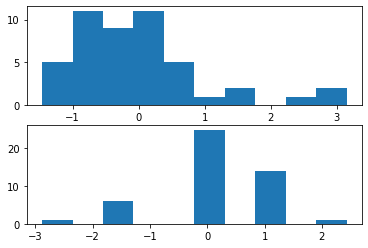

In [25]:
X_renorm=(X-_avgs)/_stds
plt.subplot(211)
plt.hist(X_renorm[:,0])
plt.subplot(212)
plt.hist(X_renorm[:,1]);

In [26]:
X=np.append([[1]]*len(X),X_renorm,axis=1)
X[:10,:]

matrix([[ 1.        ,  0.13141542, -0.22609337],
        [ 1.        , -0.5096407 , -0.22609337],
        [ 1.        ,  0.5079087 , -0.22609337],
        [ 1.        , -0.74367706, -1.5543919 ],
        [ 1.        ,  1.27107075,  1.10220517],
        [ 1.        , -0.01994505,  1.10220517],
        [ 1.        , -0.59358852, -0.22609337],
        [ 1.        , -0.72968575, -0.22609337],
        [ 1.        , -0.78946678, -0.22609337],
        [ 1.        , -0.64446599, -0.22609337]])

In [27]:
theta0=np.matrix(np.zeros(X.shape[1])).T
print(theta0)

[[0.]
 [0.]
 [0.]]


Solution:  [[340412.56301439 109370.05670466  -6500.61509507]]


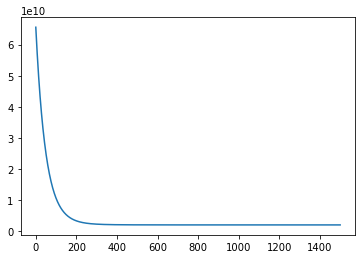

In [28]:
sol,js=descend_default(X,y,theta0)
print('Solution: ',sol.T)
plt.plot(js);

Since we have renormalized our features, to use the solution on the original values we need to rescale:<br>
$y=\sum_{i=0\dots m}\theta_i\frac{x_i-\mu_i}{\sigma_i}$

In [29]:
def predict(x,theta,mu,sigma):
    '''
    Predict value
    :param: x np.array of features
    :param: theta np.matrix of solution
    :param: mu, sigma normalization parameter
    :return: prediction of hypothesis on x
    '''
    _ren=np.matrix(np.append([1],(x-mu)/sigma))
    assert(theta.shape==(_ren.shape[1],1))
    return (_ren*theta)[0,0]

Price of a 3 bedroom 1650sqft apartment prediction:

Test result for data 1650 and 3

In [30]:
predict([1650.,3.],sol,avgs,stds)

293098.4666757651

## Using Scipy optimizations

We can use scipy library to do minimizations. Via ```scipy.opmtimize```

Repeating, first we read in the data, and perform feature normalization:<br>
$x'=\frac{x-\mu}{\sigma}$

In [31]:
X,y=np.matrix(data[:,:-1]),np.matrix(data[:,-1:])
print(X[:10])

[[2.104e+03 3.000e+00]
 [1.600e+03 3.000e+00]
 [2.400e+03 3.000e+00]
 [1.416e+03 2.000e+00]
 [3.000e+03 4.000e+00]
 [1.985e+03 4.000e+00]
 [1.534e+03 3.000e+00]
 [1.427e+03 3.000e+00]
 [1.380e+03 3.000e+00]
 [1.494e+03 3.000e+00]]


In [32]:
def normalize_features(X):
    '''
    Normalize the input feature matrix
    :return: the normalized matrix and the mean and average matrixes
    '''
    _m = np.matrix( X.shape[0]*np.mean(X,axis=0).tolist() )
    _s = np.matrix( X.shape[0]*np.std(X,axis=0).tolist() )
    return ((X-_m)/_s,_m,_s)

Finally create the data with constant term added.

In [33]:
X_norm, avgs, stds = normalize_features(X)
X1=np.append([[1]]*len(X),X_norm,axis=1)
print(X1[:10,:])

[[ 1.          0.13141542 -0.22609337]
 [ 1.         -0.5096407  -0.22609337]
 [ 1.          0.5079087  -0.22609337]
 [ 1.         -0.74367706 -1.5543919 ]
 [ 1.          1.27107075  1.10220517]
 [ 1.         -0.01994505  1.10220517]
 [ 1.         -0.59358852 -0.22609337]
 [ 1.         -0.72968575 -0.22609337]
 [ 1.         -0.78946678 -0.22609337]
 [ 1.         -0.64446599 -0.22609337]]


The hypotesys function:<br>
$h_\theta(x)=X\cdot\theta$<br>
and the cost function:<br>
$J(\theta)=\frac{1}{2m}(X\cdot\theta-y)^T(X\cdot\theta-y)$

In [29]:
#cost = lambda X, y, theta: 0.5/X.shape[0]*(X*theta-y).T*(X*theta-y)

The function to minimize is:

In [34]:
to_minimize = lambda theta, X, Y: costF(X,Y,np.matrix(theta).T)

In [35]:
res=fmin_bfgs(to_minimize,np.zeros(X1.shape[1]),
             args=(X1,y))
print(res)
print('Predicted on [1650.,3.]=',predict([1650.,3.],np.matrix(res).T,avgs[0].A1,stds[0].A1))

Optimization terminated successfully.
         Current function value: 2043280065.451488
         Iterations: 13
         Function evaluations: 208
         Gradient evaluations: 52
[340412.40071471 109447.71999051  -6572.86902402]
Predicted on [1650.,3.]= 293079.99927837175


Derivative are numerically calculated, but can be passed for higher precision.<br>
$\frac{\partial}{\partial\theta}J=\frac{1}{m}X^T\cdot(X\cdot\theta-y)$

In [32]:
cost_fun = lambda theta, X, Y: costF(X,Y,np.matrix(theta).T)
costder_fun = lambda theta, X, Y: (1./X.shape[0]*X.T*(X*(np.matrix(theta)).T-Y)).A1
res=fmin_bfgs(
    cost_fun,
    np.zeros(X1.shape[1]),
    costder_fun,
    args=(X1,y)
)
print(res)

Optimization terminated successfully.
         Current function value: 2043280050.602829
         Iterations: 10
         Function evaluations: 19
         Gradient evaluations: 19
[340412.65957455 109447.79646971  -6578.35485411]


Test result with a data with 1650 and 3, check result is the same as the one obtained with gradient descent

In [33]:
predict([1650.,3.],np.matrix(res).T, avgs[0].A1, stds[0].A1)

293081.46433494036

The difference is 0.005%

## Using sklearn

Let's use `sklearn.linear_model` to fit the data with an instance of `LinearRegression` object. Normalization of data can be done by model. Together with fitting intercept.

In [36]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
result = model.fit(data[:,:-1],data[:,-1])

In [37]:
result.predict([[1650.,3.]])

array([293081.4643349])